## Quantum Teleportation Circuit

Quantum teleportation is a protocol that uses entanglement and classical communication to transfer the state of a qubit from one location (Alice) to another (Bob) without physically moving the qubit.

**Objective:**  
Teleport the state  
\begin{equation*}
    \ket{\psi} = \alpha\ket{0} + \beta\ket{1}
\end{equation*}
from Alice's qubit to Bob's qubit.

This implementation of the quantum teleportation protocol is inspired by the Qiskit tutorial ([Entanglement in action](https://learning.quantum.ibm.com/course/basics-of-quantum-information/entanglement-in-action#qiskit-implementation)).



## Step-by-Step Breakdown

1. **State Preparation:**  
   Alice prepares her qubit in the unknown state $\ket{\psi}$.  

2. **Entanglement Creation:**  
   A Bell pair is generated between Alice’s ancilla qubit and Bob’s qubit.  

3. **Bell Measurement:**  
   Alice measures her data qubit and ancilla qubit in the Bell basis to entangle them.  

4. **Classical Communication:**  
   Alice sends the measurement results (2 bits) to Bob via a classical channel.  

5. **Conditional Correction:**  
   Depending on the received bits, Bob applies the necessary Pauli gates ($X$ and/or $Z$) to recover the original state on his qubit.


In [1]:
# Qiskit core and simulator imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UGate
from qiskit.result import marginal_distribution
from numpy import pi, random

In [2]:
def initialize_register():
    """
    Create and name all quantum and classical registers:
      - alice_qubit: holds the state |ψ⟩ to be teleported
      - alice_ebit : Alice’s half of the Bell pair
      - bob_ebit   : Bob’s half of the Bell pair
      - a, b       : classical bits for Alice’s measurement outcomes
    """
    alice_qubit = QuantumRegister(1, "Q")   # Data qubit to teleport
    alice_ebit  = QuantumRegister(1, "A")   # Alice’s EPR qubit
    bob_ebit    = QuantumRegister(1, "B")   # Bob’s EPR qubit
    a = ClassicalRegister(1, "a")           # Bit for measuring alice_ebit
    b = ClassicalRegister(1, "b")           # Bit for measuring alice_qubit
    return alice_qubit, alice_ebit, bob_ebit, a, b

In [3]:
def create_entangled_pair(qc, alice_ebit, bob_ebit):
    """Create a Bell pair between Alice and Bob."""
    qc.h(alice_ebit)            # Hadamard: |0⟩ → (|0⟩+|1⟩)/√2
    qc.cx(alice_ebit, bob_ebit) # CNOT: entangles alice_ebit with bob_ebit
    qc.barrier()                # Visual separator in the circuit diagram

def alice_operations(qc, alice_qubit, alice_ebit):
    """Entangle Alice’s data qubit with her half of the Bell pair."""
    qc.cx(alice_qubit, alice_ebit)  # CNOT: data qubit → alice_ebit
    qc.h(alice_qubit)               # Hadamard: prepare for Bell-basis measurement
    qc.barrier()                    # Separator

def alice_measurement(qc, alice_qubit, alice_ebit, a, b):
    """Measure Alice’s qubits and store results in classical bits."""
    qc.measure(alice_ebit, a)   # Measure entangled qubit into bit a
    qc.measure(alice_qubit, b)  # Measure data qubit into bit b
    qc.barrier()                # Separator

def bob_correction(qc, bob_ebit, a, b):
    """Apply conditional corrections on Bob’s qubit based on Alice’s bits."""
    # If Alice’s first bit a == 1, apply X to Bob
    with qc.if_test((a, 1)):
        qc.x(bob_ebit)
    # If Alice’s second bit b == 1, apply Z to Bob
    with qc.if_test((b, 1)):
        qc.z(bob_ebit)


In [4]:
def apply_random_gate(qc, qubit):
    # Sample three Euler angles uniformly from [0, 2π)
    theta = random.random() * 2 * pi
    phi   = random.random() * 2 * pi
    lamb  = random.random() * 2 * pi

    # Create the U(θ, φ, λ) gate with a label for clarity in the diagram
    random_gate = UGate(theta, phi, lamb)

    # Append the random unitary to the specified qubit
    qc.append(random_gate, [qubit])

    qc.barrier()

    return random_gate


def final_verification(qc, random_gate, bob_ebit):
    # Create a new classical register to store the measurement result
    result = ClassicalRegister(1, "Result")
    qc.add_register(result)

    # Apply the inverse of the random unitary to Bob’s qubit
    qc.append(random_gate.inverse(), [bob_ebit])

    # Measure Bob’s qubit into the ‘Result’ bit
    qc.measure(bob_ebit, result)

    return qc


## Protocol Assembly

Now we combine all the steps into a single quantum circuit.  
This circuit follows the protocol from state preparation to final correction.  

1. **Prepare the initial state** $\ket{\psi}= U\ket{0}$.  
2. **Create entanglement** between Alice's second qubit and Bob's qubit.  
3. **Perform the Bell measurement** on Alice’s qubits.  
4. **Apply corrections** based on the classical bits sent from Alice to Bob.
5. **Unprepare Bob's final state** using the inverse of the preparation gate $U^{-1}$

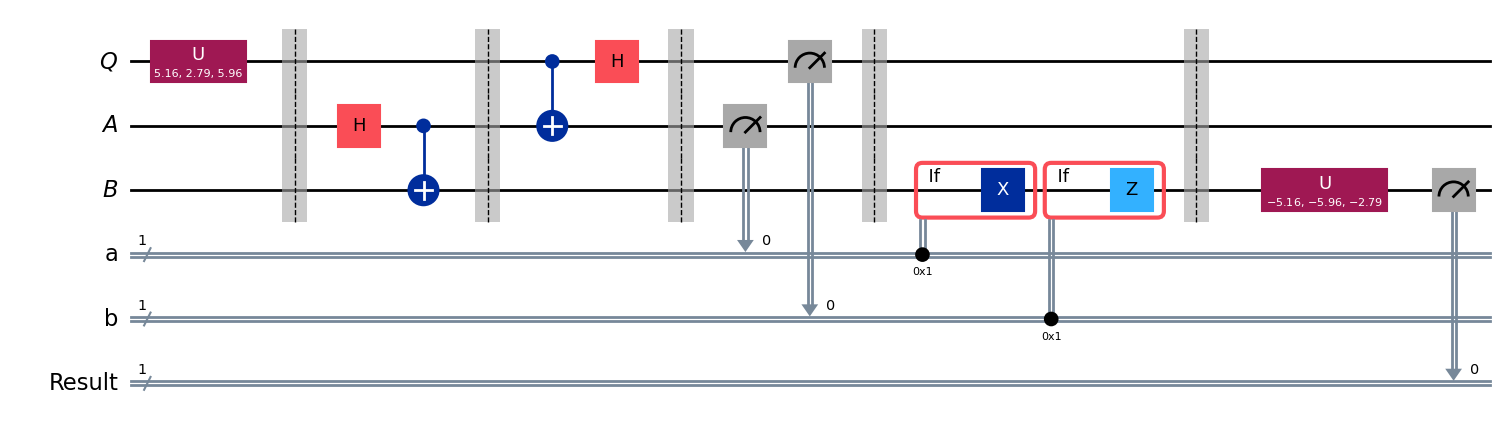

In [5]:
def assemble_full_protocol(alice_qubit, alice_ebit, bob_ebit, a, b):
    # Step 1: Initialize the protocol
    qc = QuantumCircuit(alice_qubit, alice_ebit, bob_ebit, a, b)

    # Step 2: Apply the random gate to Alice's qubit
    random_gate = apply_random_gate(qc, alice_qubit)

    # Step 3: Create the teleportation circuit
    create_entangled_pair(qc, alice_ebit, bob_ebit)
    alice_operations(qc, alice_qubit, alice_ebit)
    alice_measurement(qc, alice_qubit, alice_ebit, a, b)
    bob_correction(qc, bob_ebit, a, b)
    qc.barrier()

    # Step 4: Apply the inverse of the random gate and measure Bob's qubit
    qc = final_verification(qc, random_gate, bob_ebit)

    return qc

# Generate the registers
alice_qubit, alice_ebit, bob_ebit, a, b = initialize_register()

# Create the full teleportation circuit
qc_teleportation = assemble_full_protocol(alice_qubit, alice_ebit, bob_ebit, a, b)

# Visualize the complete circuit
display(qc_teleportation.draw(output="mpl"))

## Simulation and Measurement

To verify the teleportation, we simulate the circuit multiple times.  
The goal is to check whether the state on Bob’s qubit matches the original state prepared by Alice.  

**Expected Result:**  
After applying the inverse of the initial random unitary, Bob’s qubit should always collapse to $\ket{0}$, confirming successful teleportation.


In [6]:
# Execute the teleportation circuit on the Aer simulator
result = AerSimulator().run(qc_teleportation).result()
statistics = result.get_counts()

# Extract the marginal distribution for the verification bit. This focuses only on Bob’s final measurement outcome
filtered_statistics = marginal_distribution(statistics, [2])

# Print the filtered distribution to verify that Bob’s qubit collapsed correctly
print(filtered_statistics)


{'0': 1024}


## Verification of Results

To ensure the accuracy of teleportation, we check the measurement outcomes.  
If the protocol is correctly implemented, the result will consistently be $\ket{0}$ after reversing the initial random transformation.  

This confirms that Bob has successfully received the original qubit state from Alice.
